In [9]:
import os
import re
import pandas as pd
import numpy as np
import sys
import glob
import traceback
import json
import folium
import datetime
from ast import literal_eval

sys.path.append('/lib')
import lib.helper as helper

%matplotlib inline
%load_ext folium_magic

CURRENT_DIR = os.getcwd()
DATA_DIR = CURRENT_DIR + '/data'
RAW_DATA_DIR = DATA_DIR + '/raw'
ANALYSES_DIR = "data/analyses/"
MAPS_DIR = DATA_DIR + "/maps"
UK_REGIONS_FILE = CURRENT_DIR + '/lib/UK-regions.json'

The folium_magic extension is already loaded. To reload it, use:
  %reload_ext folium_magic


In [10]:
# Absolute or relative path to processed instructor data that we want to analyse/map (REDASH)
instructors_file = "data/processed/redash_processed_carpentry_instructors_UK_2020-04-07.csv"

In [23]:
instructors_df = pd.read_csv(instructors_file, encoding = "utf-8")
instructors_df = instructors_df.drop(labels=['first_name', 'last_name'], axis=1)
# load some data as dictionary
instructors_df.loc[~instructors_df['taught_workshops_per_year'].isnull(),['taught_workshops_per_year']] = instructors_df.loc[~instructors_df['taught_workshops_per_year'].isnull(),'taught_workshops_per_year'].apply(lambda x: literal_eval(x))
instructors_df.loc[instructors_df['taught_workshops_per_year'].isnull(),['taught_workshops_per_year']] = instructors_df.loc[instructors_df['taught_workshops_per_year'].isnull(),'taught_workshops_per_year'].apply(lambda x: {})

In [24]:
# Let's inspect our data
instructors_df.head(50)

,institution,normalised_institution,latitude,longitude,country,country_code,taught_workshops,taught_workshop_dates,taught_workshops_per_year,domains,...,swc-instructor,dc-instructor,lc-instructor,trainer,earliest_badge_awarded,year_earliest_badge_awarded,airport,airport_code,airport_latitude,airport_longitude
0,University College London,University College London,51.524774,-0.133401,United Kingdom,GB,"2016-02-17-UCL_software_carpentry,2017-07-25-U...","2016-02-17,2017-07-26,2017-10-31,2018-11-07,20...","{2016: 1, 2017: 2, 2018: 1, 2020: 1}",NaN,...,2017-12-08,NaN,NaN,NaN,2017-12-08,2017,London Heathrow,LHR,51.477500,-0.461389
1,NaN,NaN,NaN,NaN,United Kingdom,GB,"2015-01-14-oxford,2015-09-28-oxford","2015-01-14,2015-09-28",{2015: 2},NaN,...,2014-11-27,NaN,NaN,NaN,2014-11-27,2014,Exeter,EXT,50.734444,-3.413889
2,University of Edinburgh,University of Edinburgh,55.948003,-3.188111,United Kingdom,GB,"2013-05-09-oxford,2013-12-03-edinburgh,2014-12...","2013-05-09,2013-12-03,2014-12-03,2015-04-16,20...","{2013: 2, 2014: 1, 2015: 3, 2016: 3, 2017: 2, ...",['Physics'],...,2014-12-23,2016-10-06,NaN,NaN,2014-12-23,2014,Edinburgh,EDI,55.950000,-3.372500
3,University of Sussex,University of Sussex,50.864464,-0.087049,United Kingdom,GB,"2017-05-18-pitt,2017-09-14-padova,2018-05-14-e...","2017-05-18,2017-09-14,2018-05-14,2017-07-12,20...","{2017: 4, 2018: 1, 2015: 1}","['Humanities', 'Library and information science']",...,NaN,2017-06-08,NaN,NaN,2017-06-08,2017,London Gatwick,LGW,51.148056,-0.190278
4,University of Oxford,University of Oxford,51.757644,-1.262868,United Kingdom,GB,"2014-08-26-cam,2016-03-23-Imperial,2017-01-26-...","2014-08-26,2016-03-23,2017-01-26,2018-01-09,20...","{2014: 1, 2016: 1, 2017: 1, 2018: 1, 2019: 1}","['Genetics', ' genomics', ' bioinformatics']",...,2014-05-09,2016-11-15,NaN,NaN,2014-05-09,2014,London Heathrow,LHR,51.477500,-0.461389
5,University of Manchester,University of Manchester,NaN,NaN,United Kingdom,GB,"2015-11-09-manchester,2017-11-06-manchester,20...","2015-11-09,2017-11-06,2019-10-21","{2015: 1, 2017: 1, 2019: 1}",NaN,...,2019-01-07,NaN,NaN,NaN,2019-01-07,2019,Manchester,MAN,53.353611,-2.274722
6,"EPCC, University of Edinburgh","EPCC, University of Edinburgh",NaN,NaN,United Kingdom,GB,"2015-11-25-edinburgh,2018-01-09-oxford,2019-06...","2015-11-25,2018-01-09,2019-06-26,2019-11-12,20...","{2015: 1, 2018: 1, 2019: 3, 2020: 2}","['Computer science/electrical engineering', 'H...",...,2015-05-26,2016-01-27,NaN,NaN,2015-05-26,2015,Edinburgh,EDI,55.950000,-3.372500
7,University of Edinburgh,University of Edinburgh,55.948003,-3.188111,United Kingdom,GB,"2013-04-04-ucl,2013-09-27-ucl,2014-02-18-UCL","2013-04-04,2013-09-27,2014-02-18","{2013: 2, 2014: 1}",NaN,...,2014-07-22,NaN,NaN,NaN,2014-07-22,2014,Edinburgh,EDI,55.950000,-3.372500
8,British Trust for Ornithology,British Trust for Ornithology,NaN,NaN,United Kingdom,GB,NaN,NaN,{},"['Planetary sciences (geology', ' climatology'...",...,2017-12-08,NaN,NaN,NaN,2017-12-08,2017,Stansted,STN,51.885000,0.235000
9,University of Cambridge,University of Cambridge,52.205317,0.116642,United Kingdom,GB,2017-01-18-CAM,2017-01-18,{2017: 1},"['Genetics', ' genomics', ' bioinformatics', '...",...,2016-11-11,2016-11-11,NaN,NaN,2016-11-11,2016,Stansted,STN,51.885000,0.235000


In [5]:
# Absolute or relative path to processed instructor data that we want to analyse/map (AMY)
instructors_file_amy = "data/processed/amy_processed_carpentry_instructors_UK_2020-03-22.csv"
instructors_df_amy = pd.read_csv(instructors_file_amy, encoding = "utf-8")
instructors_df_amy.head(50)

,institution,institutional_region,normalised_institution,latitude,longitude,country,country_code,swc-instructor,dc-instructor,lc-instructor,trainer,year_earliest_instructor_badge_awarded,badges,domains,lessons,airport,airport_code,airport_latitude,airport_longitude,airport_region
0,University College London,London,University College London,51.524774,-0.133401,United Kingdom,GB,2019-05-09,NaN,NaN,NaN,2019,['swc-instructor'],"['Education', 'Humanities', 'Library and infor...",[],NaN,NaN,NaN,NaN,NaN
1,University College London,London,University College London,51.524774,-0.133401,United Kingdom,GB,2017-12-08,NaN,NaN,NaN,2017,['swc-instructor'],[],[],London Heathrow,LHR,51.477500,-0.461389,London
2,University College London,London,University College London,51.524774,-0.133401,United Kingdom,GB,2019-11-28,NaN,NaN,NaN,2019,['swc-instructor'],"['Computer science/electrical engineering', 'E...",[],NaN,NaN,NaN,NaN,NaN
3,Imperial College London,NaN,Imperial College London,NaN,NaN,United Kingdom,GB,2016-01-19,NaN,NaN,NaN,2016,['swc-instructor'],['Computer science/electrical engineering'],"['dc/python', 'swc/matlab', 'swc/python']",London Heathrow,LHR,51.477500,-0.461389,London
4,Microsoft,North West,Microsoft,53.479047,-2.238965,United Kingdom,GB,NaN,2017-06-15,NaN,2018-03-12,2017,"['dc-instructor', 'maintainer', 'trainer']","['Computer science/electrical engineering', 'E...","['dc/python', 'dc/r', 'dc/shell', 'swc/git', '...",Manchester,MAN,53.353611,-2.274722,North West
5,NaN,NaN,NaN,NaN,NaN,United Kingdom,GB,2014-11-27,NaN,NaN,NaN,2014,['swc-instructor'],[],"['dc/python', 'dc/shell', 'dc/sql', 'swc/git',...",Exeter,EXT,50.734444,-3.413889,South West
6,Imperial College London,NaN,Imperial College London,NaN,NaN,United Kingdom,GB,2019-02-27,NaN,NaN,NaN,2019,['swc-instructor'],"['Computer science/electrical engineering', 'P...",['swc/python'],London Gatwick,LGW,51.148056,-0.190278,South East
7,University of Florida,NaN,University of Florida,NaN,NaN,United Kingdom,GB,2018-03-20,NaN,NaN,NaN,2018,['swc-instructor'],['Mathematics/statistics'],"['dc/python', 'dc/r', 'dc/spreadsheets', 'dc/s...",London Heathrow,LHR,51.477500,-0.461389,London
8,University of Edinburgh,Scotland,University of Edinburgh,55.948003,-3.188111,United Kingdom,GB,2014-12-23,2016-10-06,NaN,NaN,2014,"['swc-instructor', 'dc-instructor']",['Physics'],"['dc/r', 'dc/shell', 'swc/git', 'swc/make', 's...",Edinburgh,EDI,55.950000,-3.372500,Scotland
9,University of Southampton,South East,University of Southampton,50.934180,-1.395675,United Kingdom,GB,NaN,2017-09-07,NaN,NaN,2017,['dc-instructor'],"['Civil, mechanical, chemical, or nuclear engi...","['dc/r', 'dc/shell', 'dc/spreadsheets', 'swc/g...",Southampton,SOU,50.950000,-1.356667,South East


In [25]:
instructors_df.columns

Index(['institution', 'normalised_institution', 'latitude', 'longitude',
       'country', 'country_code', 'taught_workshops', 'taught_workshop_dates',
       'taught_workshops_per_year', 'domains', 'badges', 'badges_dates',
       'swc-instructor', 'dc-instructor', 'lc-instructor', 'trainer',
       'earliest_badge_awarded', 'year_earliest_badge_awarded', 'airport',
       'airport_code', 'airport_latitude', 'airport_longitude'],
      dtype='object')

In [26]:
instructors_df.dtypes

institution                     object
normalised_institution          object
latitude                       float64
longitude                      float64
country                         object
country_code                    object
taught_workshops                object
taught_workshop_dates           object
taught_workshops_per_year       object
domains                         object
badges                          object
badges_dates                    object
swc-instructor                  object
dc-instructor                   object
lc-instructor                   object
trainer                         object
earliest_badge_awarded          object
year_earliest_badge_awarded      int64
airport                         object
airport_code                    object
airport_latitude               float64
airport_longitude              float64
dtype: object

In [27]:
print(type(instructors_df['taught_workshop_dates'][0]))
print(instructors_df['taught_workshop_dates'][0])

<class 'str'>
2016-02-17,2017-07-26,2017-10-31,2018-11-07,2020-02-18


In [ ]:
instructors_df_amy.columns

In [28]:
# How many instructors are there in total?
instructors_df.index.size

256

In [29]:
# Convert list of strings into list of dates for 'taught_workshop_dates' column (turn NaN into [])
instructors_df['taught_workshop_dates'] = instructors_df['taught_workshop_dates'].str.split(',')
instructors_df.loc[instructors_df['taught_workshop_dates'].isnull(), ['taught_workshop_dates']] = instructors_df.loc[instructors_df['taught_workshop_dates'].isnull(), 'taught_workshop_dates'].apply(lambda x: [])
instructors_df['taught_workshop_dates'] = instructors_df['taught_workshop_dates'].apply(lambda list: [datetime.datetime.strptime(date_str, '%Y-%m-%d').date() for date_str in list])

# Convert list of strings into list of dates for ' ' column (turn NaN into [])
instructors_df['taught_workshops'] = instructors_df['taught_workshops'].str.split(',')
instructors_df.loc[instructors_df['taught_workshops'].isnull(), ['taught_workshops']] = instructors_df.loc[instructors_df['taught_workshops'].isnull(), 'taught_workshop_dates'].apply(lambda x: [])

In [32]:
# Get the date of the last taught workshop
instructors_workshops_df = pd.DataFrame(instructors_df[['taught_workshops', 'taught_workshop_dates', 'taught_workshops_per_year']])
instructors_workshops_df['last_taught_workshop_date'] = instructors_workshops_df['taught_workshop_dates'].apply(lambda x: max(x) if (x != []) else None)
instructors_workshops_df.head(10)

,taught_workshops,taught_workshop_dates,taught_workshops_per_year,last_taught_workshop_date
0,"[2016-02-17-UCL_software_carpentry, 2017-07-25...","[2016-02-17, 2017-07-26, 2017-10-31, 2018-11-0...","{2016: 1, 2017: 2, 2018: 1, 2020: 1}",2020-02-18
1,"[2015-01-14-oxford, 2015-09-28-oxford]","[2015-01-14, 2015-09-28]",{2015: 2},2015-09-28
2,"[2013-05-09-oxford, 2013-12-03-edinburgh, 2014...","[2013-05-09, 2013-12-03, 2014-12-03, 2015-04-1...","{2013: 2, 2014: 1, 2015: 3, 2016: 3, 2017: 2, ...",2019-10-09
3,"[2017-05-18-pitt, 2017-09-14-padova, 2018-05-1...","[2017-05-18, 2017-09-14, 2018-05-14, 2017-07-1...","{2017: 4, 2018: 1, 2015: 1}",2018-05-14
4,"[2014-08-26-cam, 2016-03-23-Imperial, 2017-01-...","[2014-08-26, 2016-03-23, 2017-01-26, 2018-01-0...","{2014: 1, 2016: 1, 2017: 1, 2018: 1, 2019: 1}",2019-05-14
5,"[2015-11-09-manchester, 2017-11-06-manchester,...","[2015-11-09, 2017-11-06, 2019-10-21]","{2015: 1, 2017: 1, 2019: 1}",2019-10-21
6,"[2015-11-25-edinburgh, 2018-01-09-oxford, 2019...","[2015-11-25, 2018-01-09, 2019-06-26, 2019-11-1...","{2015: 1, 2018: 1, 2019: 3, 2020: 2}",2020-04-30
7,"[2013-04-04-ucl, 2013-09-27-ucl, 2014-02-18-UCL]","[2013-04-04, 2013-09-27, 2014-02-18]","{2013: 2, 2014: 1}",2014-02-18
8,[],[],{},None
9,[2017-01-18-CAM],[2017-01-18],{2017: 1},2017-01-18


In [51]:
# Extract column for each year containing number of workshops taught that year by instructor 
years = ['2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020']
for year in years: 
    instructors_workshops_df[year] = instructors_workshops_df['taught_workshops_per_year'].apply(lambda x: x.get(int(year), 0))
instructors_workshops_df

,taught_workshops,taught_workshop_dates,taught_workshops_per_year,last_taught_workshop_date,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,"[2016-02-17-UCL_software_carpentry, 2017-07-25...","[2016-02-17, 2017-07-26, 2017-10-31, 2018-11-0...","{2016: 1, 2017: 2, 2018: 1, 2020: 1}",2020-02-18,0,0,0,0,1,2,1,0,1
1,"[2015-01-14-oxford, 2015-09-28-oxford]","[2015-01-14, 2015-09-28]",{2015: 2},2015-09-28,0,0,0,2,0,0,0,0,0
2,"[2013-05-09-oxford, 2013-12-03-edinburgh, 2014...","[2013-05-09, 2013-12-03, 2014-12-03, 2015-04-1...","{2013: 2, 2014: 1, 2015: 3, 2016: 3, 2017: 2, ...",2019-10-09,0,2,1,3,3,2,1,4,0
3,"[2017-05-18-pitt, 2017-09-14-padova, 2018-05-1...","[2017-05-18, 2017-09-14, 2018-05-14, 2017-07-1...","{2017: 4, 2018: 1, 2015: 1}",2018-05-14,0,0,0,1,0,4,1,0,0
4,"[2014-08-26-cam, 2016-03-23-Imperial, 2017-01-...","[2014-08-26, 2016-03-23, 2017-01-26, 2018-01-0...","{2014: 1, 2016: 1, 2017: 1, 2018: 1, 2019: 1}",2019-05-14,0,0,1,0,1,1,1,1,0
5,"[2015-11-09-manchester, 2017-11-06-manchester,...","[2015-11-09, 2017-11-06, 2019-10-21]","{2015: 1, 2017: 1, 2019: 1}",2019-10-21,0,0,0,1,0,1,0,1,0
6,"[2015-11-25-edinburgh, 2018-01-09-oxford, 2019...","[2015-11-25, 2018-01-09, 2019-06-26, 2019-11-1...","{2015: 1, 2018: 1, 2019: 3, 2020: 2}",2020-04-30,0,0,0,1,0,0,1,3,2
7,"[2013-04-04-ucl, 2013-09-27-ucl, 2014-02-18-UCL]","[2013-04-04, 2013-09-27, 2014-02-18]","{2013: 2, 2014: 1}",2014-02-18,0,2,1,0,0,0,0,0,0
8,[],[],{},None,0,0,0,0,0,0,0,0,0
9,[2017-01-18-CAM],[2017-01-18],{2017: 1},2017-01-18,0,0,0,0,0,1,0,0,0


In [63]:
# Average number of workshop taught across all active years
instructors_workshops_df['avarage_taught_workshops_per_year'] = instructors_workshops_df[years].replace(0, np.NaN).mean(axis=1)
# instructors_workshops_df['avarage_taught_workshops_per_year'] = instructors_workshops_df['avarage_taught_workshops_per_year'].replace(np.NaN, 0)
instructors_workshops_df

,taught_workshops,taught_workshop_dates,taught_workshops_per_year,last_taught_workshop_date,2012,2013,2014,2015,2016,2017,2018,2019,2020,avarage_taught_workshops_per_year,is_active
0,"[2016-02-17-UCL_software_carpentry, 2017-07-25...","[2016-02-17, 2017-07-26, 2017-10-31, 2018-11-0...","{2016: 1, 2017: 2, 2018: 1, 2020: 1}",2020-02-18,0,0,0,0,1,2,1,0,1,1.250000,True
1,"[2015-01-14-oxford, 2015-09-28-oxford]","[2015-01-14, 2015-09-28]",{2015: 2},2015-09-28,0,0,0,2,0,0,0,0,0,2.000000,False
2,"[2013-05-09-oxford, 2013-12-03-edinburgh, 2014...","[2013-05-09, 2013-12-03, 2014-12-03, 2015-04-1...","{2013: 2, 2014: 1, 2015: 3, 2016: 3, 2017: 2, ...",2019-10-09,0,2,1,3,3,2,1,4,0,2.285714,True
3,"[2017-05-18-pitt, 2017-09-14-padova, 2018-05-1...","[2017-05-18, 2017-09-14, 2018-05-14, 2017-07-1...","{2017: 4, 2018: 1, 2015: 1}",2018-05-14,0,0,0,1,0,4,1,0,0,2.000000,True
4,"[2014-08-26-cam, 2016-03-23-Imperial, 2017-01-...","[2014-08-26, 2016-03-23, 2017-01-26, 2018-01-0...","{2014: 1, 2016: 1, 2017: 1, 2018: 1, 2019: 1}",2019-05-14,0,0,1,0,1,1,1,1,0,1.000000,True
5,"[2015-11-09-manchester, 2017-11-06-manchester,...","[2015-11-09, 2017-11-06, 2019-10-21]","{2015: 1, 2017: 1, 2019: 1}",2019-10-21,0,0,0,1,0,1,0,1,0,1.000000,True
6,"[2015-11-25-edinburgh, 2018-01-09-oxford, 2019...","[2015-11-25, 2018-01-09, 2019-06-26, 2019-11-1...","{2015: 1, 2018: 1, 2019: 3, 2020: 2}",2020-04-30,0,0,0,1,0,0,1,3,2,1.750000,True
7,"[2013-04-04-ucl, 2013-09-27-ucl, 2014-02-18-UCL]","[2013-04-04, 2013-09-27, 2014-02-18]","{2013: 2, 2014: 1}",2014-02-18,0,2,1,0,0,0,0,0,0,1.500000,False
8,[],[],{},None,0,0,0,0,0,0,0,0,0,NaN,False
9,[2017-01-18-CAM],[2017-01-18],{2017: 1},2017-01-18,0,0,0,0,0,1,0,0,0,1.000000,False


In [64]:
print(instructors_workshops_df.dtypes)
print(instructors_workshops_df['taught_workshop_dates'][0])
print(type(instructors_workshops_df['last_taught_workshop_date'][0]))
print(instructors_workshops_df.index)
instructors_workshops_df

taught_workshops                      object
taught_workshop_dates                 object
taught_workshops_per_year             object
last_taught_workshop_date             object
2012                                   int64
2013                                   int64
2014                                   int64
2015                                   int64
2016                                   int64
2017                                   int64
2018                                   int64
2019                                   int64
2020                                   int64
avarage_taught_workshops_per_year    float64
is_active                               bool
dtype: object
[datetime.date(2016, 2, 17), datetime.date(2017, 7, 26), datetime.date(2017, 10, 31), datetime.date(2018, 11, 7), datetime.date(2020, 2, 18)]
<class 'datetime.date'>
RangeIndex(start=0, stop=256, step=1)


,taught_workshops,taught_workshop_dates,taught_workshops_per_year,last_taught_workshop_date,2012,2013,2014,2015,2016,2017,2018,2019,2020,avarage_taught_workshops_per_year,is_active
0,"[2016-02-17-UCL_software_carpentry, 2017-07-25...","[2016-02-17, 2017-07-26, 2017-10-31, 2018-11-0...","{2016: 1, 2017: 2, 2018: 1, 2020: 1}",2020-02-18,0,0,0,0,1,2,1,0,1,1.250000,True
1,"[2015-01-14-oxford, 2015-09-28-oxford]","[2015-01-14, 2015-09-28]",{2015: 2},2015-09-28,0,0,0,2,0,0,0,0,0,2.000000,False
2,"[2013-05-09-oxford, 2013-12-03-edinburgh, 2014...","[2013-05-09, 2013-12-03, 2014-12-03, 2015-04-1...","{2013: 2, 2014: 1, 2015: 3, 2016: 3, 2017: 2, ...",2019-10-09,0,2,1,3,3,2,1,4,0,2.285714,True
3,"[2017-05-18-pitt, 2017-09-14-padova, 2018-05-1...","[2017-05-18, 2017-09-14, 2018-05-14, 2017-07-1...","{2017: 4, 2018: 1, 2015: 1}",2018-05-14,0,0,0,1,0,4,1,0,0,2.000000,True
4,"[2014-08-26-cam, 2016-03-23-Imperial, 2017-01-...","[2014-08-26, 2016-03-23, 2017-01-26, 2018-01-0...","{2014: 1, 2016: 1, 2017: 1, 2018: 1, 2019: 1}",2019-05-14,0,0,1,0,1,1,1,1,0,1.000000,True
5,"[2015-11-09-manchester, 2017-11-06-manchester,...","[2015-11-09, 2017-11-06, 2019-10-21]","{2015: 1, 2017: 1, 2019: 1}",2019-10-21,0,0,0,1,0,1,0,1,0,1.000000,True
6,"[2015-11-25-edinburgh, 2018-01-09-oxford, 2019...","[2015-11-25, 2018-01-09, 2019-06-26, 2019-11-1...","{2015: 1, 2018: 1, 2019: 3, 2020: 2}",2020-04-30,0,0,0,1,0,0,1,3,2,1.750000,True
7,"[2013-04-04-ucl, 2013-09-27-ucl, 2014-02-18-UCL]","[2013-04-04, 2013-09-27, 2014-02-18]","{2013: 2, 2014: 1}",2014-02-18,0,2,1,0,0,0,0,0,0,1.500000,False
8,[],[],{},None,0,0,0,0,0,0,0,0,0,NaN,False
9,[2017-01-18-CAM],[2017-01-18],{2017: 1},2017-01-18,0,0,0,0,0,1,0,0,0,1.000000,False


In [65]:
# How many instructors taught 0 times?
instructors_workshops_df[instructors_workshops_df['last_taught_workshop_date'].isnull()]

,taught_workshops,taught_workshop_dates,taught_workshops_per_year,last_taught_workshop_date,2012,2013,2014,2015,2016,2017,2018,2019,2020,avarage_taught_workshops_per_year,is_active
8,[],[],{},None,0,0,0,0,0,0,0,0,0,NaN,False
17,[],[],{},None,0,0,0,0,0,0,0,0,0,NaN,False
21,[],[],{},None,0,0,0,0,0,0,0,0,0,NaN,False
26,[],[],{},None,0,0,0,0,0,0,0,0,0,NaN,False
28,[],[],{},None,0,0,0,0,0,0,0,0,0,NaN,False
29,[],[],{},None,0,0,0,0,0,0,0,0,0,NaN,False
36,[],[],{},None,0,0,0,0,0,0,0,0,0,NaN,False
38,[],[],{},None,0,0,0,0,0,0,0,0,0,NaN,False
50,[],[],{},None,0,0,0,0,0,0,0,0,0,NaN,False
53,[],[],{},None,0,0,0,0,0,0,0,0,0,NaN,False


In [66]:
# Let's define active and inactive instructors
# Active = taught in the past 2 years. Inactive = everyone else.
def is_active(dates_list):
    if dates_list == [] or (datetime.date.today() - max(dates_list)).days > 712:
        return False
    else:
        return True
    
instructors_workshops_df['is_active'] = instructors_workshops_df['taught_workshop_dates'].apply(lambda x: is_active(x))
instructors_workshops_df

,taught_workshops,taught_workshop_dates,taught_workshops_per_year,last_taught_workshop_date,2012,2013,2014,2015,2016,2017,2018,2019,2020,avarage_taught_workshops_per_year,is_active
0,"[2016-02-17-UCL_software_carpentry, 2017-07-25...","[2016-02-17, 2017-07-26, 2017-10-31, 2018-11-0...","{2016: 1, 2017: 2, 2018: 1, 2020: 1}",2020-02-18,0,0,0,0,1,2,1,0,1,1.250000,True
1,"[2015-01-14-oxford, 2015-09-28-oxford]","[2015-01-14, 2015-09-28]",{2015: 2},2015-09-28,0,0,0,2,0,0,0,0,0,2.000000,False
2,"[2013-05-09-oxford, 2013-12-03-edinburgh, 2014...","[2013-05-09, 2013-12-03, 2014-12-03, 2015-04-1...","{2013: 2, 2014: 1, 2015: 3, 2016: 3, 2017: 2, ...",2019-10-09,0,2,1,3,3,2,1,4,0,2.285714,True
3,"[2017-05-18-pitt, 2017-09-14-padova, 2018-05-1...","[2017-05-18, 2017-09-14, 2018-05-14, 2017-07-1...","{2017: 4, 2018: 1, 2015: 1}",2018-05-14,0,0,0,1,0,4,1,0,0,2.000000,True
4,"[2014-08-26-cam, 2016-03-23-Imperial, 2017-01-...","[2014-08-26, 2016-03-23, 2017-01-26, 2018-01-0...","{2014: 1, 2016: 1, 2017: 1, 2018: 1, 2019: 1}",2019-05-14,0,0,1,0,1,1,1,1,0,1.000000,True
5,"[2015-11-09-manchester, 2017-11-06-manchester,...","[2015-11-09, 2017-11-06, 2019-10-21]","{2015: 1, 2017: 1, 2019: 1}",2019-10-21,0,0,0,1,0,1,0,1,0,1.000000,True
6,"[2015-11-25-edinburgh, 2018-01-09-oxford, 2019...","[2015-11-25, 2018-01-09, 2019-06-26, 2019-11-1...","{2015: 1, 2018: 1, 2019: 3, 2020: 2}",2020-04-30,0,0,0,1,0,0,1,3,2,1.750000,True
7,"[2013-04-04-ucl, 2013-09-27-ucl, 2014-02-18-UCL]","[2013-04-04, 2013-09-27, 2014-02-18]","{2013: 2, 2014: 1}",2014-02-18,0,2,1,0,0,0,0,0,0,1.500000,False
8,[],[],{},None,0,0,0,0,0,0,0,0,0,NaN,False
9,[2017-01-18-CAM],[2017-01-18],{2017: 1},2017-01-18,0,0,0,0,0,1,0,0,0,1.000000,False


Number of active instructors: 101
Number of inactive instructors: 155


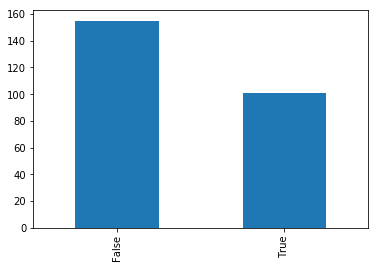

In [124]:
# How many active and inactive instructors?
active = instructors_workshops_df[instructors_workshops_df['is_active'] == True]
inactive = instructors_workshops_df[instructors_workshops_df['is_active'] != True]
print("Number of active instructors: " + str(len(active.index)))
print("Number of inactive instructors: " + str(len(inactive.index)))
instructors_workshops_df['is_active'].value_counts().plot(kind='bar')

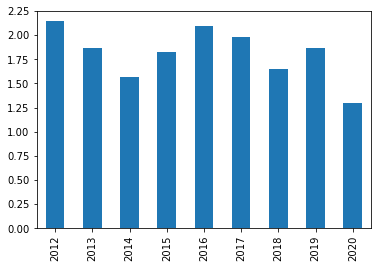

In [71]:
# Average number of workshops taught per year (for all instructors)
instructors_workshops_df[years].replace(0, np.NaN).mean(axis=0).plot(kind='bar')

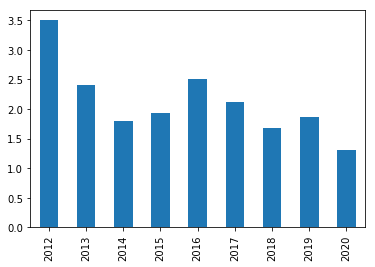

In [128]:
# Average number of workshops taught per year (for active instructors only)
active[years].replace(0, np.NaN).mean(axis=0).plot(kind='bar')

In [137]:
# Average number of workshops taught across all years while active (for inactive instructors only)
inactive[years].replace(0, np.NaN).mean(axis=0).mean()

1.5193918863091795

In [136]:
# Average number of workshops taught across all years while active (for active instructors only)
active[years].replace(0, np.NaN).mean(axis=0).mean()

2.12094782954998

In [125]:
# How long have instructors that are inactive now been active for? 
# In other words, how long do they teach before they become inactive?
def days(date_list):
    return (max(date_list) - min(date_list)).days
    
time_before_inactivity = inactive[inactive['taught_workshop_dates'].apply(lambda x: len(x)) > 0]
time_before_inactivity = time_before_inactivity['taught_workshop_dates'].apply(lambda x: days(x))
time_before_inactivity = time_before_inactivity.replace(0, np.NaN)
print("\nAverage time taught before becoming inactive (for currently inactive instuctors): " + str(time_before_inactivity.mean()) + " days.")


Average time taught before becoming inactive (for currently inactive instuctors): 407.2 days.


In [126]:
# How long have instructors that are active now been active for? 
# In other words, what is the current period of activity for active instuctors up to now
def days(date_list):
    return (max(date_list) - min(date_list)).days
    
period_of_activity = active[active['taught_workshop_dates'].apply(lambda x: len(x)) > 0]
period_of_activity = period_of_activity['taught_workshop_dates'].apply(lambda x: days(x))
period_of_activity = period_of_activity.replace(0, np.NaN)
print("\nAverage period of activity up till now (for currently active instuctors): " + str(period_of_activity.mean()) + " days.")


Average period of activity up till now (for currently active instuctors): 860.943661971831 days.


      number_of_instructors
year                       
0                         3
2012                      5
2013                     10
2014                     22
2015                     21
2016                     25
2017                     46
2018                     41
2019                     64
2020                     19


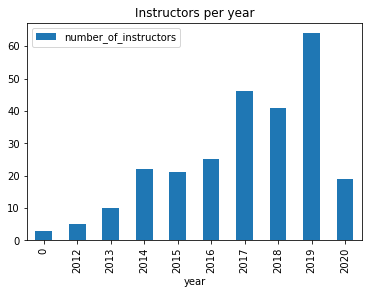

In [115]:
# How many new instructors are there for each year?
instructors_per_year = instructors_df['year_earliest_badge_awarded'].value_counts()
instructors_per_year.sort_index(ascending = True, inplace=True)
instructors_per_year.index.name = 'year'
instructors_per_year = instructors_per_year.to_frame('number_of_instructors')
print(instructors_per_year)
instructors_per_year.plot(kind='bar', legend=True, title ="Instructors per year")

Imperial College London                                                                          26
University College London                                                                        18
University of Oxford                                                                             14
University of Edinburgh                                                                          13
University of Leeds                                                                              13
The University of Manchester                                                                     11
University of Birmingham                                                                          9
University of Sheffield                                                                           9
University of Southampton                                                                         8
University of Cambridge                                                                           7


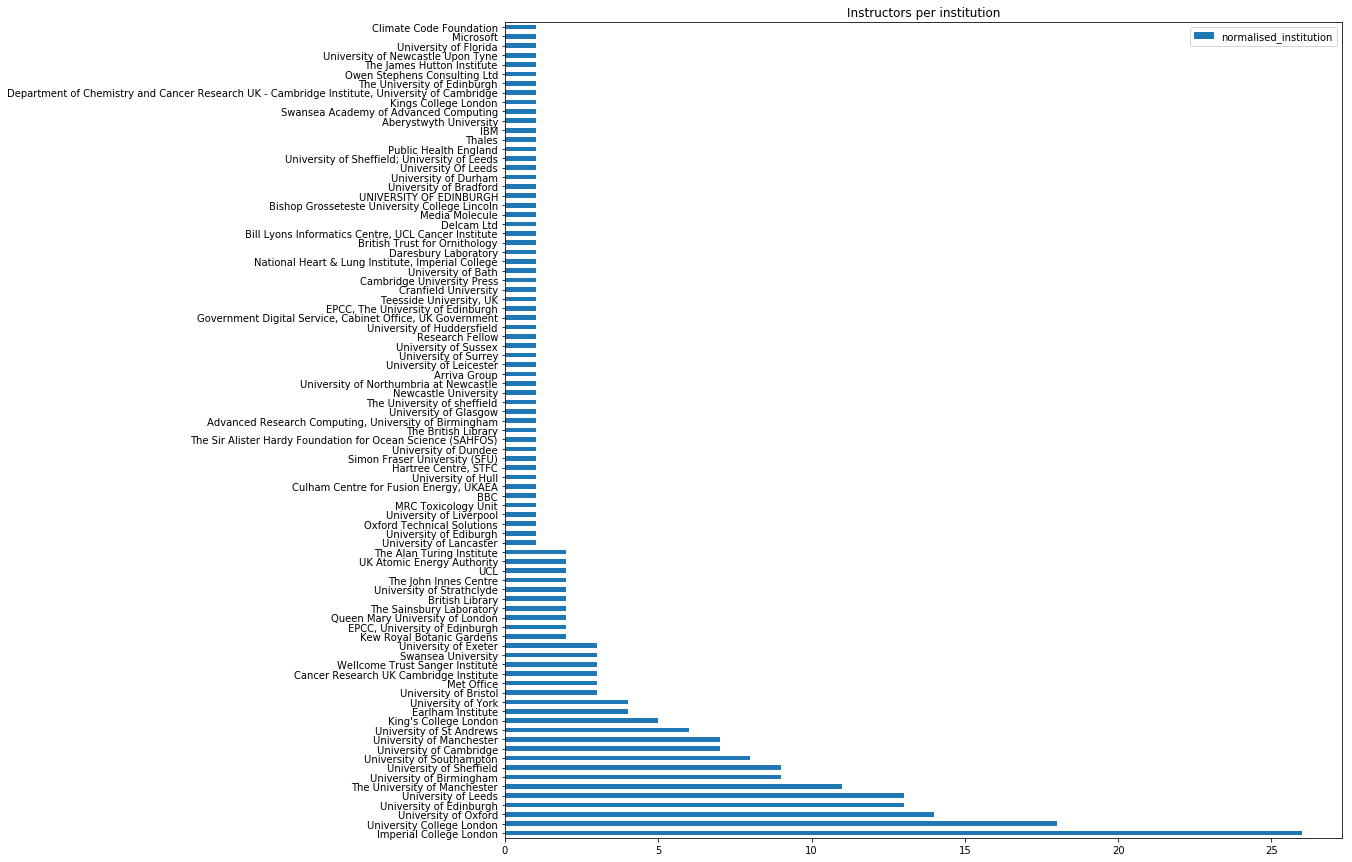

In [116]:
# How many instructors are there at each institution?
instructors_per_institution = instructors_df['normalised_institution'].value_counts()
print(instructors_per_institution)
instructors_per_institution.plot(kind='barh', legend=True, title ="Instructors per institution", figsize = (15,15))

In [117]:
# How many instructors do we not have normalised institution for?
instructors_df['normalised_institution'].isnull().sum()

8

In [118]:
# How are instructors spread over UK regions based on their affiliations?
instructors_per_region = instructors_df['institutional_region'].value_counts()
instructors_per_region.sort_values(inplace=True)
instructors_per_region.plot(kind='bar', legend=True, title ="Instructors per region")

KeyError: 'institutional_region'

In [ ]:
# How many instructors do we not have region for?
instructors_df['institutional_region'].isnull().sum()

In [ ]:
# How are instructors spread over UK regions based on the nearest airpor?
instructors_per_region_nearest_airport = instructors_df['airport_region'].value_counts()
instructors_per_region_nearest_airport.sort_values(inplace=True)
instructors_per_region_nearest_airport.plot(kind='bar', legend=True, title ="Instructors per region based on nearest airport")

In [ ]:
# How many insructors do we not have regions based on the nearest airport?
instructors_df['airport_region'].isnull().sum()

In [ ]:
# Let's merge region info - if we have institutional region - use that, if not - use airport reqion, else leave blank
instructors_df['region'] = instructors_df.apply(
    lambda x: x['institutional_region'] if pd.notnull(x['institutional_region']) else x['airport_region'],
    axis=1)
# How many instructors do we not have region for now?
print("No region info for " + str(instructors_df['region'].isnull().sum()) + ' instructors')
instructors_df[['institutional_region','airport_region', 'region']].head(50)

In [ ]:
instructors_per_region_merged = instructors_df['region'].value_counts()
instructors_per_region_merged.sort_values(inplace=True)
instructors_per_region_merged.plot(kind='bar', legend=True, title ="Instructors per (merged) region")

In [ ]:
# # Let's do a choropleth map of instructors per UK regions
# instructors_map = helper.generate_choropleth_map(instructors_df, uk_regions, "instructors")
# instructors_map

In [ ]:
# A clustered map of all instructor affiliaiton locations
# Add column 'description' which is used for popups in maps
instructors_df['popup'] = instructors_df["institution"]
instructors_map = helper.generate_map_with_clustered_markers(instructors_df.dropna(subset=['longitude', 'latitude']))
instructors_map

In [ ]:
# Save all analyses into an Excel spreadsheet
if not os.path.exists(ANALYSES_DIR):
    os.makedirs(ANALYSES_DIR)

instructors_file_name = os.path.basename(instructors_file)
instructors_file_name_without_extension = re.sub('\.csv$', '', instructors_file_name.strip())
instructors_analyses_excel_file = ANALYSES_DIR + "analysed_" + instructors_file_name_without_extension + '_from_ipynb.xlsx'

excel_writer = pd.ExcelWriter(instructors_analyses_excel_file, engine='xlsxwriter')

instructors_df.to_excel(excel_writer, sheet_name="carpentry_instructors", index=False)

# Instructors per year
instructors_per_year.to_excel(excel_writer, sheet_name='instructors_per_year', index=True)
workbook = excel_writer.book
worksheet = excel_writer.sheets['instructors_per_year']
chart = workbook.add_chart({'type': 'column'})
chart.add_series({
        'categories': ['instructors_per_year', 1, 0, len(instructors_per_year.index), 0],
        'values': ['instructors_per_year', 1, 1, len(instructors_per_year.index), 1],
        'gap': 2,
    })
chart.set_y_axis({'major_gridlines': {'visible': False}})
chart.set_legend({'position': 'none'})
chart.set_x_axis({'name': 'Year'})
chart.set_y_axis({'name': 'Number of instructors', 'major_gridlines': {'visible': False}})
chart.set_title({'name': 'Number of instructors per year'})
worksheet.insert_chart('I2', chart)

# Instructors per institution
instructors_per_institution.to_excel(excel_writer, sheet_name='instructors_per_institution', index=True)
workbook = excel_writer.book
worksheet = excel_writer.sheets['instructors_per_institution']
chart = workbook.add_chart({'type': 'bar'})
chart.add_series({
        'categories': ['instructors_per_institution', 1, 0, len(instructors_per_institution.index), 0],
        'values': ['instructors_per_institution', 1, 1, len(instructors_per_institution.index), 1],
        'gap': 2,
    })
chart.set_y_axis({'major_gridlines': {'visible': False}})
chart.set_legend({'position': 'none'})
chart.set_x_axis({'name': 'Host institution'})
chart.set_y_axis({'name': 'Number of instructors', 'major_gridlines': {'visible': False}})
chart.set_title({'name': 'Number of instructors per host'})
worksheet.insert_chart('I2', chart)

# Instructors per region
instructors_per_region_merged.to_excel(excel_writer, sheet_name='instructors_per_region', index=True)
workbook = excel_writer.book
worksheet = excel_writer.sheets['instructors_per_region']
chart = workbook.add_chart({'type': 'column'})
chart.add_series({
        'categories': ['instructors_per_region', 1, 0, len(instructors_per_region_merged.index), 0],
        'values': ['instructors_per_region', 1, 1, len(instructors_per_region_merged.index), 1],
        'gap': 2,
    })
chart.set_y_axis({'major_gridlines': {'visible': False}})
chart.set_legend({'position': 'none'})
chart.set_x_axis({'name': 'Region institution'})
chart.set_y_axis({'name': 'Number of instructors', 'major_gridlines': {'visible': False}})
chart.set_title({'name': 'Number of instructors per region'})
worksheet.insert_chart('I2', chart)

excel_writer.save()
print("Saved instructors analyses in " + instructors_analyses_excel_file)